In [1]:
from fastbook import *
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG

pd.options.display.max_rows = 20
pd.options.display.max_columns = 8

In [2]:
# Setting the path for the dataset
comp = 'bluebook-for-bulldozers'
path = URLs.path(comp)

# Loading the prepared data
to = load_pickle(path/'to.pkl')

# Splitting the data into training and validation x and y
xs,y = to.train.xs,to.train.y
valid_xs,valid_y = to.valid.xs,to.valid.y

# Replacing years <1900 with 1950
xs.loc[xs['YearMade']<1900, 'YearMade'] = 1950
valid_xs.loc[valid_xs['YearMade']<1900, 'YearMade'] = 1950

# Defining a function to calculate the RMSE
def r_mse(pred,y): return round(math.sqrt(((pred-y)**2).mean()), 6)
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)

# Defining the Random Forest model
def rf(xs, y, n_estimators=40, max_samples=200_000,
       max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

# Training our model
model = rf(xs, y);

# Tabular Modelling Deep Dive

## Model Interpretation
For tabular data, model interpretation is particularly important. For a given model, the things we are most likely to be interested in are:

- How confident are we in our predictions using a particular row of data?
- For predicting with a particular row of data, what were the most important factors, and how did they influence that prediction?
- Which columns are the strongest predictors, which can we ignore?
- Which columns are effectively redundant with each other, for purposes of prediction?
- How do predictions vary, as we vary these columns?

As we will see, random forests are particularly well suited to answering these questions. Let's start with the first one!


### Tree Variance for Prediction Confidence

We saw how the model averages the individual tree's predictions to get an overall prediction—that is, an estimate of the value. But how can we know the confidence of the estimate? One simple way is to use the standard deviation of predictions across the trees, instead of just the mean. This tells us the *relative* confidence of predictions. 

In general, we would want to be more cautious of using the results for rows where trees give very different results (higher standard deviations), compared to cases where they are more consistent (lower standard deviations).

In the earlier section on creating a random forest, we saw how to get predictions over the validation set, using a Python list comprehension to do this for each tree in the forest:

In [3]:
preds = np.stack([t.predict(valid_xs) for t in model.estimators_])

/Users/286329i/miniforge3/envs/fastai/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/Users/286329i/miniforge3/envs/fastai/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/Users/286329i/miniforge3/envs/fastai/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/Users/286329i/miniforge3/envs/fastai/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/Users/286329i/miniforge3/envs/fastai/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/Users/286

In [4]:
preds.shape

(40, 7988)

Now we have a prediction for every tree and every auction (40 trees and 7,988 auctions) in the validation set.

Using this we can get the standard deviation of the predictions over all the trees, for each auction:

In [5]:
preds_std = preds.std(0)

Here are the standard deviations for the predictions for the first five auctions—that is, the first five rows of the validation set:

In [6]:
preds_std[:5]

array([0.28891659, 0.12401689, 0.12201792, 0.24222819, 0.14102906])

As you can see, the confidence in the predictions varies widely. For some auctions, there is a low standard deviation because the trees agree. For others it's higher, as the trees don't agree. This is information that would be useful in a production setting; for instance, if you were using this model to decide what items to bid on at auction, a low-confidence prediction might cause you to look more carefully at an item before you made a bid.

### Feature Importance
It's not normally enough just to know that a model can make accurate predictions—we also want to know *how* it's making predictions. *feature importance* gives us insight into this. We can get these directly from sklearn's random forest by looking in the `feature_importances_` attribute. Here's a simple function we can use to pop them into a DataFrame and sort them:

In [7]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

The feature importances for our model show that the first few most important columns have much higher importance scores than the rest, with (not surprisingly) `YearMade` and `ProductSize` being at the top of the list:

In [8]:
fi = rf_feat_importance(model, xs)
fi[:10]

,cols,imp
57,YearMade,0.170321
30,Coupler_System,0.110101
6,ProductSize,0.098546
7,fiProductClassDesc,0.085460
54,ModelID,0.053893
65,saleElapsed,0.051368
3,fiSecondaryDesc,0.050190
32,Hydraulics_Flow,0.048229
31,Grouser_Tracks,0.042956
12,Enclosure,0.041761


A plot of the feature importances shows the relative importances more clearly:

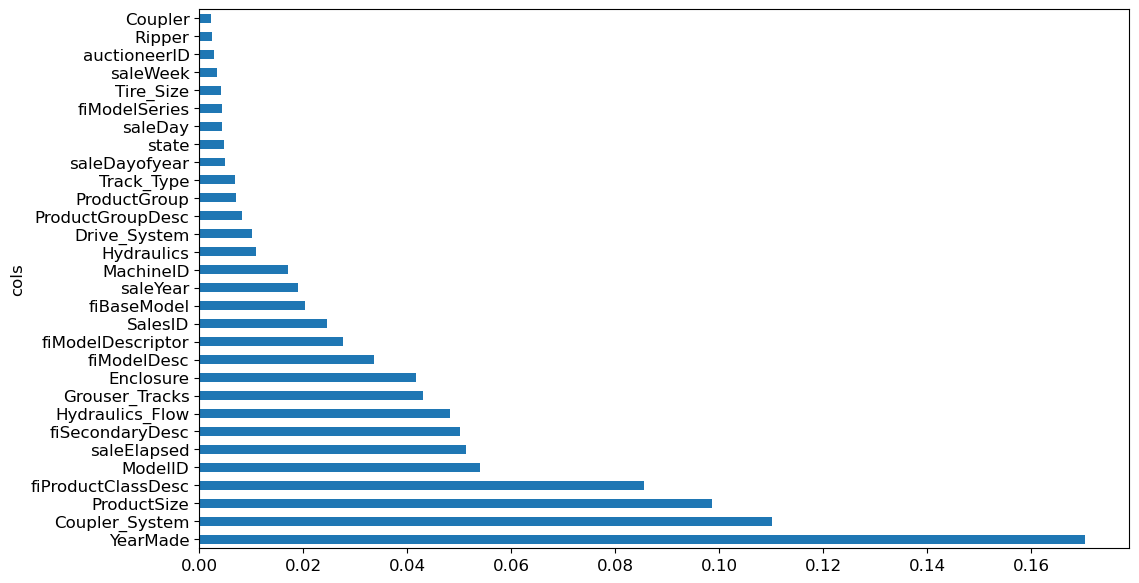

In [9]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

plot_fi(fi[:30]);

The way these importances are calculated is quite simple yet elegant. The feature importance algorithm loops through each tree, and then recursively explores each branch. At each branch, it looks to see what feature was used for that split, and how much the model improves as a result of that split. The improvement (weighted by the number of rows in that group) is added to the importance score for that feature. This is summed across all branches of all trees, and finally the scores are normalized such that they add to 1.

### Removing Low-Importance Variables
It seems likely that we could use just a subset of the columns by removing the variables of low importance and still get good results. Let's try just keeping those with a feature importance greater than 0.005:

In [10]:
to_keep = fi[fi.imp>0.005].cols
len(to_keep)

21

We can retrain our model using just this subset of the columns:

In [11]:
xs_imp = xs[to_keep]
valid_xs_imp = valid_xs[to_keep]

We can retrain our model using just this subset of the columns:

In [12]:
model = rf(xs_imp, y)

And here's the result:

In [13]:
m_rmse(model, xs_imp, y), m_rmse(model, valid_xs_imp, valid_y)

(0.181853, 0.231662)

Our accuracy is about the same, but we have far fewer columns to study:

In [14]:
len(xs.columns), len(xs_imp.columns)

(66, 21)

We've found that generally the first step to improving a model is simplifying it—78 columns was too many for us to study them all in depth! Furthermore, in practice often a simpler, more interpretable model is easier to roll out and maintain.

This also makes our feature importance plot easier to interpret. Let's look at it again:

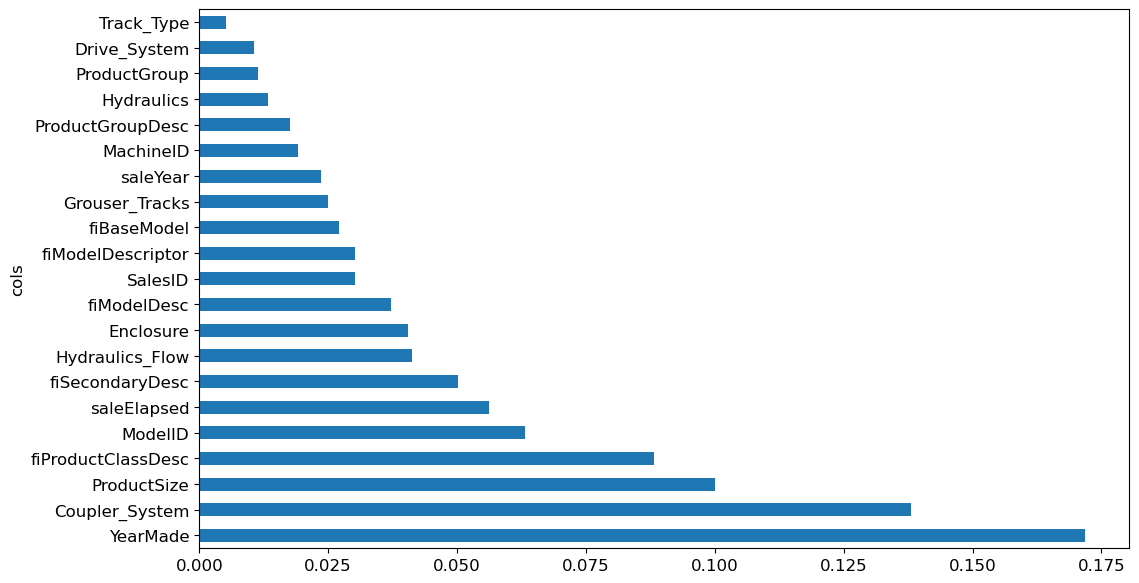

In [15]:
plot_fi(rf_feat_importance(model, xs_imp));

One thing that makes this harder to interpret is that there seem to be some variables with very similar meanings: for example, `ProductGroup` and `ProductGroupDesc`. Let's try to remove any redundent features. 

### Removing Redundant Features

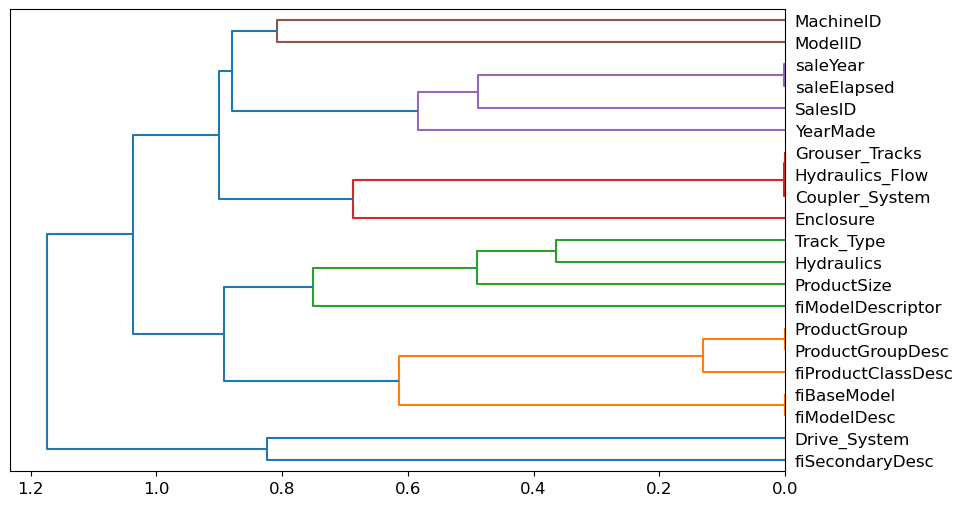

In [16]:
cluster_columns(xs_imp)

In this chart, the pairs of columns that are most similar are the ones that were merged together early, far from the "root" of the tree at the left. Unsurprisingly, the fields `ProductGroup` and `ProductGroupDesc` were merged quite early, as were `saleYear` and `saleElapsed` and `fiModelDesc` and `fiBaseModel`. These might be so closely correlated they are practically synonyms for each other.

Let's try removing some of these closely related features to see if the model can be simplified without impacting the accuracy. First, we create a function that quickly trains a random forest and returns the OOB score, by using a lower `max_samples` and higher `min_samples_leaf`. The OOB score is a number returned by sklearn that ranges between 1.0 for a perfect model and 0.0 for a random model. (In statistics it's called *R^2*, although the details aren't important for this explanation.) We don't need it to be very accurate—we're just going to use it to compare different models, based on removing some of the possibly redundant columns:

In [17]:
def get_oob(df):
    m = RandomForestRegressor(n_estimators=40, min_samples_leaf=15,
        max_samples=50000, max_features=0.5, n_jobs=-1, oob_score=True)
    m.fit(df, y)
    return m.oob_score_

Here's our baseline:

In [18]:
get_oob(xs_imp)

0.8745460050410032

Now we try removing each of our potentially redundant variables, one at a time:

In [19]:
{c:get_oob(xs_imp.drop(c, axis=1)) for c in (
    'saleYear', 'saleElapsed', 'ProductGroupDesc','ProductGroup',
    'fiModelDesc', 'fiBaseModel',
    'Hydraulics_Flow','Grouser_Tracks', 'Coupler_System')}

{'saleYear': 0.8737991987906563,
 'saleElapsed': 0.870709097845309,
 'ProductGroupDesc': 0.8750779484655821,
 'ProductGroup': 0.8759492065623438,
 'fiModelDesc': 0.8748291994543853,
 'fiBaseModel': 0.8750728645837715,
 'Hydraulics_Flow': 0.8764176915501123,
 'Grouser_Tracks': 0.876521707386068,
 'Coupler_System': 0.8764017127569202}

Now let's try dropping multiple variables. We'll drop one from each of the tightly aligned pairs we noticed earlier. Let's see what that does:

In [20]:
to_drop = ['saleYear', 'ProductGroupDesc', 'fiBaseModel', 'Grouser_Tracks']
get_oob(xs_imp.drop(to_drop, axis=1))

0.8722123520618141

Looking good! This is really not much worse than the model with all the fields. Let's create DataFrames without these columns, and save them:

In [21]:
xs_final = xs_imp.drop(to_drop, axis=1)
valid_xs_final = valid_xs_imp.drop(to_drop, axis=1)

In [22]:
save_pickle(path/'xs_final.pkl', xs_final)
save_pickle(path/'valid_xs_final.pkl', valid_xs_final)

We can load them back later with:

In [23]:
xs_final = load_pickle(path/'xs_final.pkl')
valid_xs_final = load_pickle(path/'valid_xs_final.pkl')

Now we can check our RMSE again, to confirm that the accuracy hasn't substantially changed.

In [24]:
model = rf(xs_final, y)
m_rmse(model, xs_final, y), m_rmse(model, valid_xs_final, valid_y)

(0.183709, 0.232641)

By focusing on the most important variables, and removing some redundant ones, we've greatly simplified our model. Now, let's see how those variables affect our predictions using partial dependence plots.

### Partial Dependence
As we've seen, the two most important predictors are `ProductSize` and `YearMade`. We'd like to understand the relationship between these predictors and sale price. It's a good idea to first check the count of values per category (provided by the Pandas `value_counts` method), to see how common each category is:

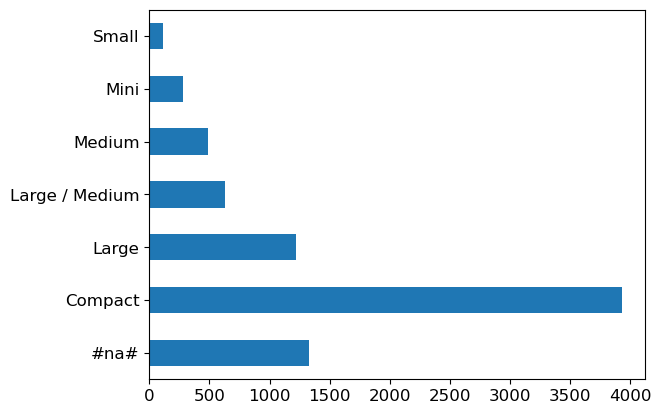

In [25]:
p = valid_xs_final['ProductSize'].value_counts(sort=False).plot.barh()
c = to.classes['ProductSize']
plt.yticks(range(len(c)), c);

The largrest group is `#na#`, which is the label fastai applies to missing values.

Let's do the same thing for `YearMade`. Since this is a numeric feature, we'll need to draw a histogram, which groups the year values into a few discrete bins:

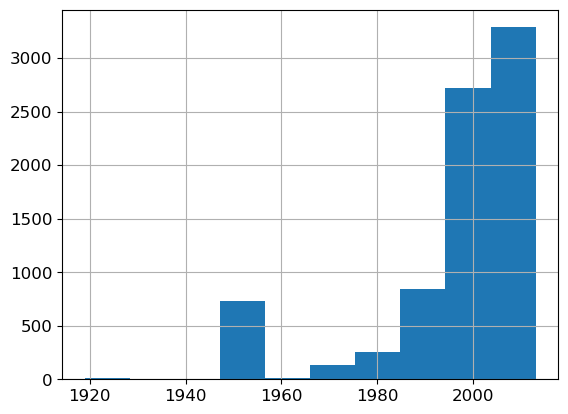

In [26]:
ax = valid_xs_final['YearMade'].hist()

Other than the special value 1950 which we used for coding missing year values, most of the data is from after 1990.

Now we're ready to look at *partial dependence plots*. Partial dependence plots try to answer the question: if a row varied on nothing other than the feature in question, how would it impact the dependent variable?

For instance, how does `YearMade` impact sale price, all other things being equal?

To answer this question, we can't just take the average sale price for each `YearMade`. The problem with that approach is that many other things vary from year to year as well, such as which products are sold, how many products have air-conditioning, inflation, and so forth. So, merely averaging over all the auctions that have the same `YearMade` would also capture the effect of how every other field also changed along with `YearMade` and how that overall change affected price.

Instead, what we do is replace every single value in the `YearMade` column with 1950, and then calculate the predicted sale price for every auction, and take the average over all auctions. Then we do the same for 1951, 1952, and so forth until our final year of 2011. This isolates the effect of only `YearMade` (even if it does so by averaging over some imagined records where we assign a `YearMade` value that might never actually exist alongside some other values). 

With these averages, we can then plot each of these years on the x-axis, and each of the predictions on the y-axis. This, finally, is a partial dependence plot. Let's take a look:

/Users/286329i/miniforge3/envs/fastai/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead
  warnings.warn(msg, category=FutureWarning)


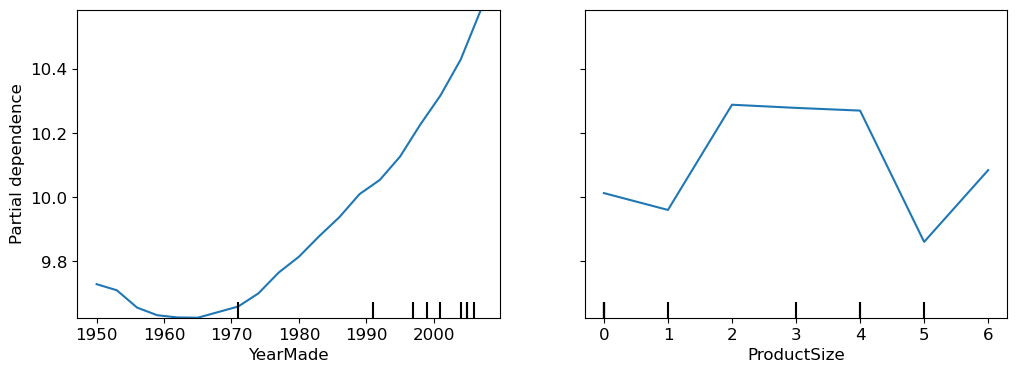

In [27]:
from sklearn.inspection import plot_partial_dependence

fig,ax = plt.subplots(figsize=(12, 4))
plot_partial_dependence(model, valid_xs_final, ['YearMade','ProductSize'],
                        grid_resolution=20, ax=ax);

Looking first of all at the `YearMade` plot, and specifically at the section covering the years after 1990 (since as we noted this is where we have the most data), we can see a nearly linear relationship between year and price. Remember that our dependent variable is after taking the logarithm, so this means that in practice there is an exponential increase in price. This is what we would expect: depreciation is generally recognized as being a multiplicative factor over time, so, for a given sale date, varying year made ought to show an exponential relationship with sale price.

The `ProductSize` partial plot is a bit concerning. It shows that the final group, which we saw is for missing values, has the lowest price. To use this insight in practice, we would want to find out *why* it's missing so often, and what that *means*. Missing values can sometimes be useful predictors—it entirely depends on what causes them to be missing. Sometimes, however, they can indicate *data leakage*.

### Data Leakage
Data leakage is subtle and can take many forms. In particular, missing values often represent data leakage.

For instance, Jeremy competed in a Kaggle competition designed to predict which researchers would end up receiving research grants. The information was provided by a university and included thousands of examples of research projects, along with information about the researchers involved and data on whether or not each grant was eventually accepted. The university hoped to be able to use the models developed in this competition to rank which grant applications were most likely to succeed, so it could prioritize its processing.

Jeremy used a random forest to model the data, and then used feature importance to find out which features were most predictive. He noticed three surprising things:

- The model was able to correctly predict who would receive grants over 95% of the time.
- Apparently meaningless identifier columns were the most important predictors.
- The day of week and day of year columns were also highly predictive; for instance, the vast majority of grant applications dated on a Sunday were accepted, and many accepted grant applications were dated on January 1.

For the identifier columns, one partial dependence plot per column showed that when the information was missing the application was almost always rejected. It turned out that in practice, the university only filled out much of this information *after* a grant application was accepted. Often, for applications that were not accepted, it was just left blank. Therefore, this information was not something that was actually available at the time that the application was received, and it would not be available for a predictive model—it was data leakage.

In the same way, the final processing of successful applications was often done automatically as a batch at the end of the week, or the end of the year. It was this final processing date which ended up in the data, so again, this information, while predictive, was not actually available at the time that the application was received.

This example showcases the most practical and simple approaches to identifying data leakage, which are to build a model and then:

- Check whether the accuracy of the model is *too good to be true*.
- Look for important predictors that don't make sense in practice.
- Look for partial dependence plot results that don't make sense in practice.

Thinking back to our bear detector, this mirrors the advice that we provided in <<chapter_production>>—it is often a good idea to build a model first and then do your data cleaning, rather than vice versa. The model can help you identify potentially problematic data issues.

It can also help you identify which factors influence specific predictions, with tree interpreters.

### Tree Interpreters
At the start of this section, we said that we wanted to be able to answer five questions:

- How confident are we in our predictions using a particular row of data?
- For predicting with a particular row of data, what were the most important factors, and how did they influence that prediction?
- Which columns are the strongest predictors?
- Which columns are effectively redundant with each other, for purposes of prediction?
- How do predictions vary, as we vary these columns?

We've handled four of these already; only the second question remains. To answer this question, we need to use the `treeinterpreter` library. We'll also use the `waterfallcharts` library to draw the chart of the results.

    !pip install treeinterpreter
    !pip install waterfallcharts

In [28]:
import warnings
warnings.simplefilter('ignore', FutureWarning)

from treeinterpreter import treeinterpreter
from waterfall_chart import plot as waterfall

We have already seen how to compute feature importances across the entire random forest. The basic idea was to look at the contribution of each variable to improving the model, at each branch of every tree, and then add up all of these contributions per variable.

We can do exactly the same thing, but for just a single row of data. For instance, let's say we are looking at some particular item at auction. Our model might predict that this item will be very expensive, and we want to know why. So, we take that one row of data and put it through the first decision tree, looking to see what split is used at each point throughout the tree. For each split, we see what the increase or decrease in the addition is, compared to the parent node of the tree. We do this for every tree, and add up the total change in importance by split variable.

For instance, let's pick the first few rows of our validation set:

In [29]:
row = valid_xs_final.iloc[:5]

We can then pass these to `treeinterpreter`:

In [30]:
prediction,bias,contributions = treeinterpreter.predict(model, row.values)

`prediction` is simply the prediction that the random forest makes. `bias` is the prediction based on taking the mean of the dependent variable (i.e., the *model* that is the root of every tree). `contributions` is the most interesting bit—it tells us the total change in prediction due to each of the independent variables. Therefore, the sum of `contributions` plus `bias` must equal the `prediction`, for each row. Let's look just at the first row:

In [31]:
prediction[0], bias[0], contributions[0].sum()

(array([10.02655456]), 10.104513595136046, -0.07795903082344241)

The clearest way to display the contributions is with a *waterfall plot*. This shows how the positive and negative contributions from all the independent variables sum up to create the final prediction, which is the righthand column labeled "net" here:

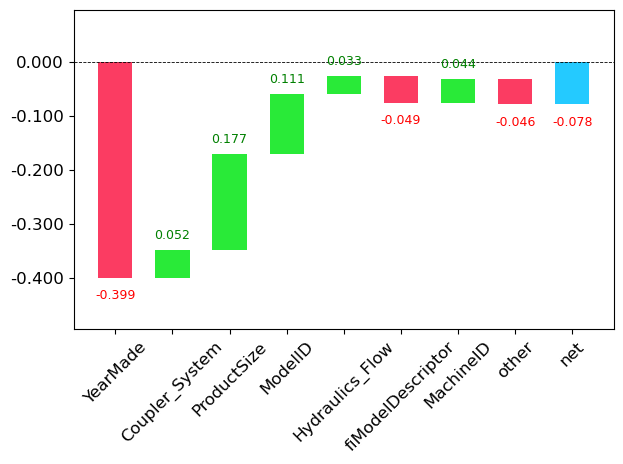

In [32]:
waterfall(valid_xs_final.columns, contributions[0], threshold=0.08, 
          rotation_value=45,formatting='{:,.3f}');

This kind of information is most useful in production, rather than during model development. You can use it to provide useful information to users of your data product about the underlying reasoning behind the predictions.

### Extrapolation Problem
A random forest just averages the predictions of a number of trees. And a tree simply predicts the average value of the rows in a leaf. Therefore, a tree and a random forest can never predict values outside of the range of the training data. This is particularly problematic for data where there is a trend over time, such as inflation, and you wish to make predictions for a future time. Your predictions will be systematically too low.

But the problem extends beyond time variables. Random forests are not able to extrapolate outside of the types of data they have seen, in a more general sense. That's why we need to make sure our validation set does not contain out-of-domain data.

### Finding Out-of-Domain Data
Sometimes it is hard to know whether your test set is distributed in the same way as your training data, or, if it is different, what columns reflect that difference. There's actually an easy way to figure this out, which is to use a random forest!

But in this case we don't use the random forest to predict our actual dependent variable. Instead, we try to predict whether a row is in the validation set or the training set. To see this in action, let's combine our training and validation sets together, create a dependent variable that represents which dataset each row comes from, build a random forest using that data, and get its feature importance:

In [33]:
df_dom = pd.concat([xs_final, valid_xs_final])
is_valid = np.array([0]*len(xs_final) + [1]*len(valid_xs_final))

m = rf(df_dom, is_valid)
rf_feat_importance(m, df_dom)[:6]

,cols,imp
5,saleElapsed,0.882853
11,SalesID,0.095330
12,MachineID,0.015567
0,YearMade,0.001859
8,Enclosure,0.000847
4,ModelID,0.000804


This shows that there are three columns that differ significantly between the training and validation sets: `saleElapsed`, `SalesID`, and `MachineID`. It's fairly obvious why this is the case for `saleElapsed`: it's the number of days between the start of the dataset and each row, so it directly encodes the date. The difference in `SalesID` suggests that identifiers for auction sales might increment over time. `MachineID` suggests something similar might be happening for individual items sold in those auctions.

Let's get a baseline of the original random forest model's RMSE, then see what the effect is of removing each of these columns in turn:

In [34]:
model = rf(xs_final, y)
print('orig', m_rmse(model, valid_xs_final, valid_y))

for c in ('SalesID','saleElapsed','MachineID'):
    model = rf(xs_final.drop(c,axis=1), y)
    print(c, m_rmse(model, valid_xs_final.drop(c,axis=1), valid_y))

orig 0.232628
SalesID 0.230503
saleElapsed 0.236197
MachineID 0.23044


It looks like we should be able to remove `SalesID` and `MachineID` without losing any accuracy. Let's check:

In [35]:
time_vars = ['SalesID','MachineID']
xs_final_time = xs_final.drop(time_vars, axis=1)
valid_xs_time = valid_xs_final.drop(time_vars, axis=1)

m = rf(xs_final_time, y)
m_rmse(m, valid_xs_time, valid_y)

0.229286

Removing these variables has slightly improved the model's accuracy; but more importantly, it should make it more resilient over time, and easier to maintain and understand. We recommend that for all datasets you try building a model where your dependent variable is `is_valid`, like we did here. It can often uncover subtle *domain shift* issues that you may otherwise miss.

One thing that might help in our case is to simply avoid using old data. Often, old data shows relationships that just aren't valid any more. Let's try just using the most recent few years of the data:

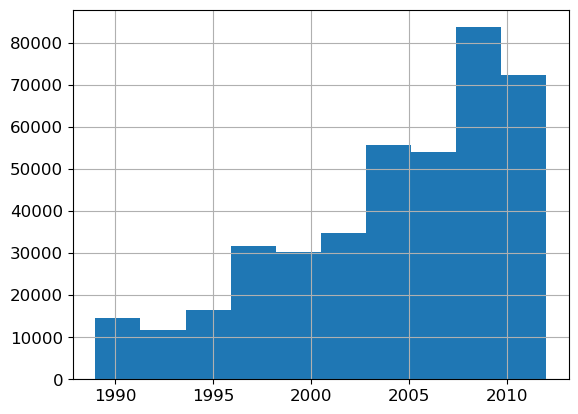

In [36]:
xs['saleYear'].hist();

Here's the result of training on this subset:

In [37]:
filt = xs['saleYear']>2004
xs_filt = xs_final_time[filt]
y_filt = y[filt]

In [38]:
model = rf(xs_filt, y_filt)
m_rmse(m, xs_filt, y_filt), m_rmse(model, valid_xs_time, valid_y)

(0.191393, 0.229012)

It's a tiny bit better, which shows that you shouldn't always just use your entire dataset; sometimes a subset can be better.